In [1]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator, StandardScaler

In [2]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model_TZD.pkl', 'rb') as f:
    speculator = pickle.load(f)
# speculator._build_params_prior()
# speculator.bounds = [speculator.prior[key] for key in speculator.params_name]
speculator.network.eval();

In [3]:
noise = None # 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

In [4]:
y_sfh = np.random.multivariate_normal(mean=[6, 0], cov=[[0.5, 0.3], [0.3, 0.1]], size=5000)
y_sfh = Tensor(y_sfh).to('cuda')

y_logz = torch.normal(-0.5, 0.2, size=(len(y_sfh), 1)).to('cuda')
y_dust2 = torch.normal(1.5, 0.5, size=(len(y_sfh), 1)).to('cuda')

y_stellar_mass = torch.normal(10, 0.4, size=(len(y_sfh), 1)).to('cuda')
y_redshift = torch.normal(0.08, 0.015, size=(len(y_sfh), 1)).to('cuda')

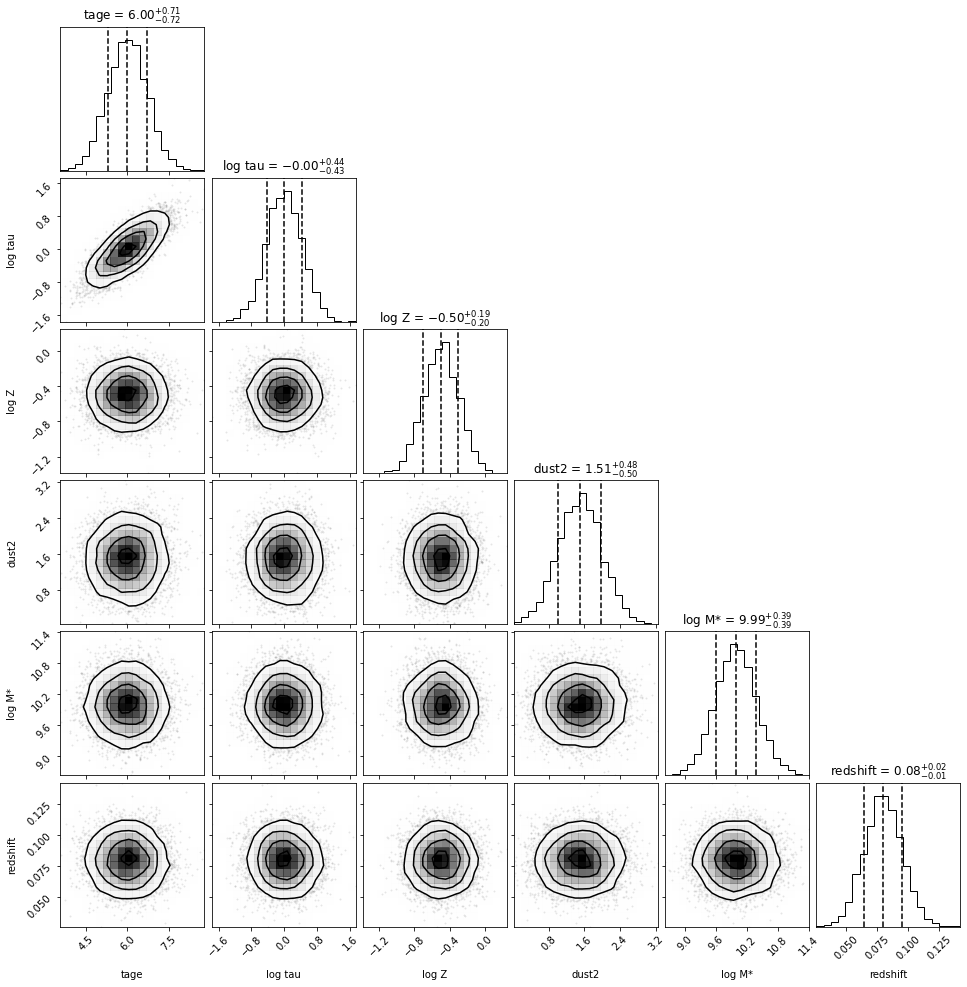

In [9]:
Y_truth = torch.hstack([y_sfh, y_logz, y_dust2, y_stellar_mass, y_redshift])

X_data = speculator._predict_mag_with_mass_redshift(
    Y_truth,
    filterset=['sdss_{0}0'.format(b) for b in 'ugriz'],
    noise=noise, 
    noise_model_dir=noise_model_dir).cpu().detach().numpy()

X_data = Tensor(X_data).to('cuda')
flag = ~(torch.isnan(X_data).any(dim=1) | torch.isinf(X_data).any(dim=1))
X_data = X_data[flag]
Y_truth = Y_truth[flag]

figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=['tage', 'log tau', 'log Z', 'dust2', 'log M*', 'redshift'],
                       smooth=0.7,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [10]:
import umap

In [13]:
reducer = umap.UMAP(random_state=42)
reducer.fit(X_data.cpu().detach().numpy())

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [17]:
with open('./umap_mags.pkl', 'wb') as f:
    pickle.dump(reducer, f)

In [14]:
embedding = reducer.transform(X_data.cpu().detach().numpy())
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(4993, 2)

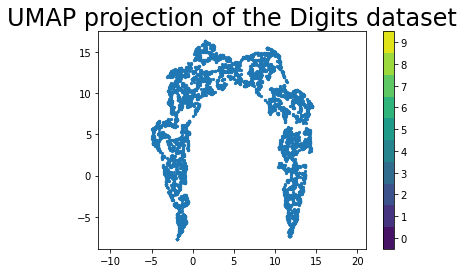

In [16]:
plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);